In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk("drone"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

drone/class_dict_seg.csv
drone/dataset/semantic_drone_dataset/label_images_semantic/008.png
drone/dataset/semantic_drone_dataset/label_images_semantic/428.png
drone/dataset/semantic_drone_dataset/label_images_semantic/043.png
drone/dataset/semantic_drone_dataset/label_images_semantic/222.png
drone/dataset/semantic_drone_dataset/label_images_semantic/344.png
drone/dataset/semantic_drone_dataset/label_images_semantic/060.png
drone/dataset/semantic_drone_dataset/label_images_semantic/299.png
drone/dataset/semantic_drone_dataset/label_images_semantic/112.png
drone/dataset/semantic_drone_dataset/label_images_semantic/277.png
drone/dataset/semantic_drone_dataset/label_images_semantic/429.png
drone/dataset/semantic_drone_dataset/label_images_semantic/159.png
drone/dataset/semantic_drone_dataset/label_images_semantic/135.png
drone/dataset/semantic_drone_dataset/label_images_semantic/590.png
drone/dataset/semantic_drone_dataset/label_images_semantic/494.png
drone/dataset/semantic_drone_dataset/

# Imports 

In [2]:
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2

from PIL import Image

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
df = pd.read_csv("drone/class_dict_seg.csv")

In [4]:
df.head(24)

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


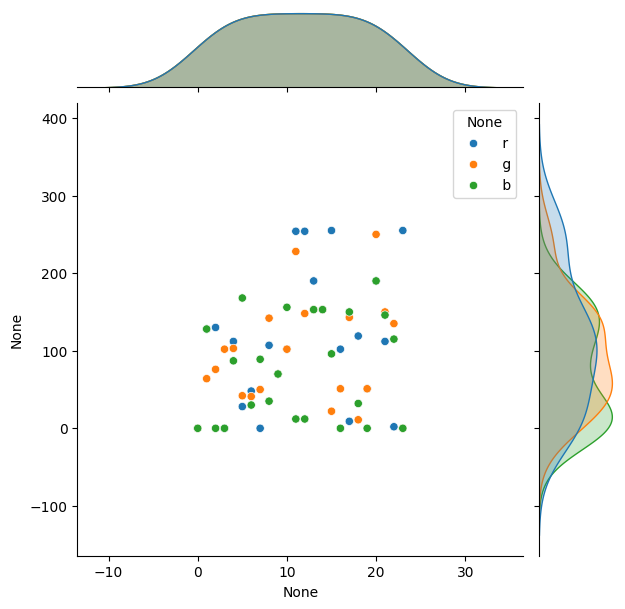

In [5]:
sns.jointplot(df)

# Data Visualization


In [6]:
image_path = "drone/dataset/semantic_drone_dataset/label_images_semantic"
original_image_path = "drone/dataset/semantic_drone_dataset/original_images"

In [7]:
files = os.listdir(image_path)

# Filter out only the image files (assuming image files have extensions like .jpg, .png, etc.)
image_files = [file for file in files if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]
image_files = sorted(image_files)

#list o image_paths
image_list  = []
# Print the list of image files
for image_file in image_files:
    image_list.append(image_path+"/"+image_file)
    
    
files_2 = os.listdir(original_image_path)
# Filter out only the image files (assuming image files have extensions like .jpg, .png, etc.)
image_files = [file for file in files_2 if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]
image_files = sorted(image_files)

#list o image_paths
original_image_list  = []
# Print the list of image files
for image_file in image_files:
    original_image_list.append(original_image_path+"/"+image_file)

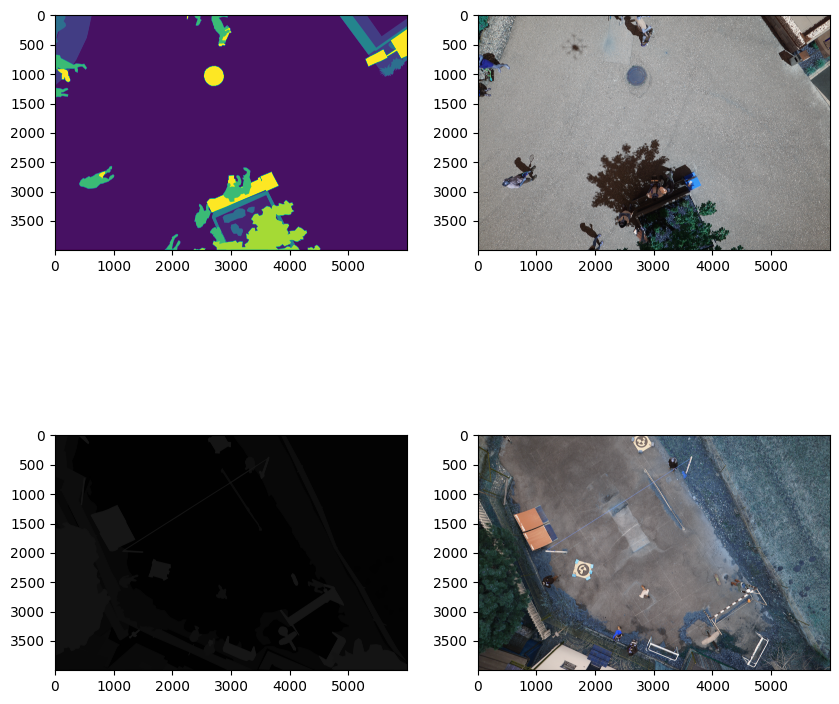

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0][0].imshow(Image.open(image_list[0]))
ax[0][1].imshow(cv2.imread(original_image_list[0]))
ax[1][0].imshow(cv2.imread(image_list[1]))
ax[1][1].imshow(cv2.imread(original_image_list[1]))

In [9]:
IMAGE_PATH = "drone/dataset/semantic_drone_dataset/original_images"
MASK_PATH = "drone/dataset/semantic_drone_dataset/label_images_semantic"

In [10]:
n_classes = 23 

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [43]:
df.iloc[0]

id    515
Name: 0, dtype: object

In [39]:
#spliting the data for traning , testing and validation
X_trainval , X_test = train_test_split(df['id'].values,test_size = 0.1,random_state = 42)
X_train , X_val = train_test_split(X_trainval , test_size = 0.15 , random_state = 42)

In [37]:
randomized_df = df.sample(frac=1).reset_index(drop=True)
split_dfs = [randomized_df.iloc[i::3].reset_index(drop=True) for i in range(3)]

In [42]:
X_train[0] , X_val[0] 

('219', '283')

In [35]:
type(X_trainval)

numpy.ndarray

In [38]:
split_dfs

[      id
 0    454
 1    193
 2    166
 3    478
 4    323
 ..   ...
 129  302
 130  334
 131  120
 132  154
 133  543
 
 [134 rows x 1 columns],
       id
 0    217
 1    298
 2    518
 3    521
 4    062
 ..   ...
 128  591
 129  273
 130  057
 131  200
 132  425
 
 [133 rows x 1 columns],
       id
 0    413
 1    507
 2    438
 3    220
 4    215
 ..   ...
 128  073
 129  426
 130  508
 131  559
 132  164
 
 [133 rows x 1 columns]]

# Dataset Creation

In [12]:
class DroneDataset(Dataset):

    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_full_path = os.path.join(self.img_path, self.X[idx] + ".jpg")
        mask_full_path = os.path.join(self.mask_path, self.X[idx] + ".png")

        # Load the image and mask
        img = cv2.imread(img_full_path)
        if img is None:
            raise FileNotFoundError(f"Image not found at {img_full_path}")

        mask = cv2.imread(mask_full_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found at {mask_full_path}")

        # Convert color from BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']

        if self.transform is None:
            img = Image.fromarray(img)

        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()

        if self.patches:
            img, mask = self.tiles(img, mask)

        return img, mask

    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)

        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)

        return img_patches, mask_patches

In [13]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader
batch_size= 1 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)      

# Model Initialization

In [14]:
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

# Model Traning 

In [15]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        correct = torch.eq(output, mask).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

In [16]:
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for clas in range(0, n_classes): #loop per pixel class
            true_class = pred_mask == clas
            true_label = mask == clas

            if true_label.long().sum().item() == 0: #no exist label in this loop
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot(pred_masks, true_masks):
    n_classes = len(np.unique(true_masks))  # Number of unique classes
    class_colors = plt.cm.tab20.colors  # Colors for different classes
    
    n_images = pred_masks.shape[0]  # Number of images
    
    # Create subplots outside the loop
    fig, axes = plt.subplots(n_images, 2, figsize=(10, 5 * n_images))
    
    for i in range(n_images):
        im_pred = axes[i, 0].imshow(pred_masks[i, 0], cmap='tab20', vmin=0, vmax=n_classes - 1)  # Assuming single channel masks
        axes[i, 0].set_title('Predicted Mask')
        axes[i, 0].set_axis_off()
        fig.colorbar(im_pred, ax=axes[i, 0], label='Predicted Class')
        
        im_true = axes[i, 1].imshow(true_masks[i], cmap='tab20', vmin=0, vmax=n_classes - 1)
        axes[i, 1].set_title('True Mask')
        axes[i, 1].set_axis_off()
        fig.colorbar(im_true, ax=axes[i, 1], label='True Class')
    
    plt.tight_layout()
    plt.show()



In [18]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            

            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            

            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))


            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, 'Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    

            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
            
            #plot the mIOU metric 
#             plot(output.cpu().detach().numpy(), mask.cpu().detach().numpy())    
            
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [19]:
max_lr = 1e-3
epoch = 2
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.562 
Epoch:1/2.. Train Loss: 2.089.. Val Loss: 1.562.. Train mIoU:0.085.. Val mIoU: 0.122.. Train Acc:0.406.. Val Acc:0.516.. Time: 3.81m


  0%|          | 0/306 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

Loss Decreasing.. 1.562 >> 1.270 
Epoch:2/2.. Train Loss: 1.501.. Val Loss: 1.270.. Train mIoU:0.144.. Val mIoU: 0.175.. Train Acc:0.555.. Val Acc:0.608.. Time: 3.72m
Total time: 7.52 m


In [20]:
torch.save(model, 'Unet-Mobilenet.pt')

In [21]:
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()
    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

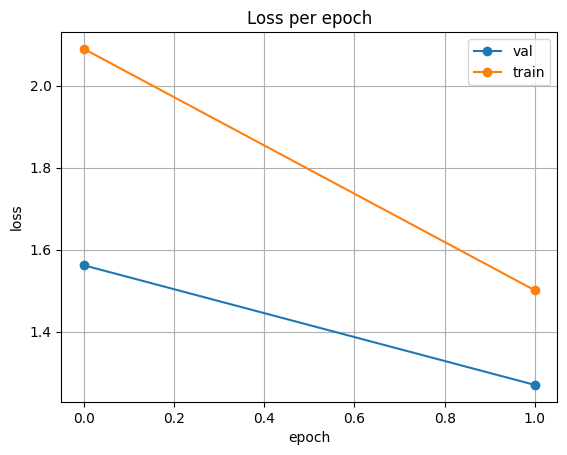

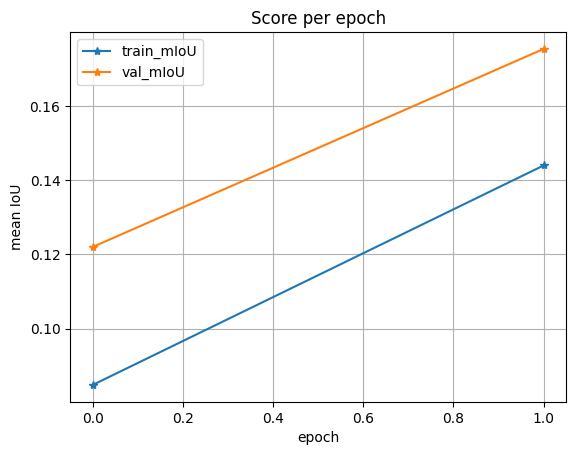

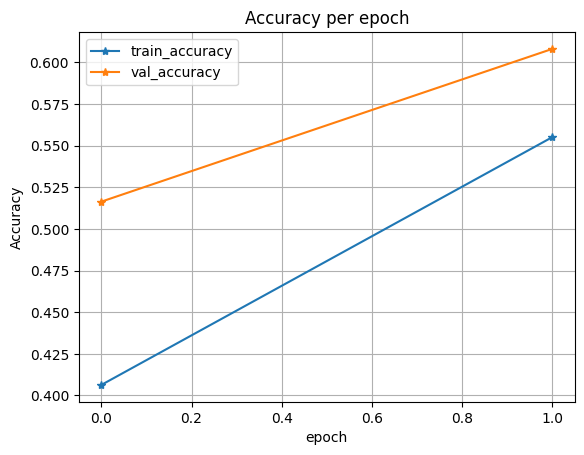

In [22]:
plot_loss(history)
plot_score(history)
plot_acc(history)

In [23]:
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img_full_path = os.path.join(self.img_path, self.X[idx] + '.jpg')
        mask_full_path = os.path.join(self.mask_path, self.X[idx] + '.png')
        
        img = cv2.imread(img_full_path)
        if img is None:
            raise FileNotFoundError(f"Image not found at {img_full_path}")
        
        mask = cv2.imread(mask_full_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(f"Mask not found at {mask_full_path}")
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

In [24]:
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score


In [25]:
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

In [26]:


image, mask = test_set[3]
pred_mask, score = predict_image_mask_miou(model, image, mask)



In [27]:


def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou



In [28]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [29]:


def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy



In [30]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

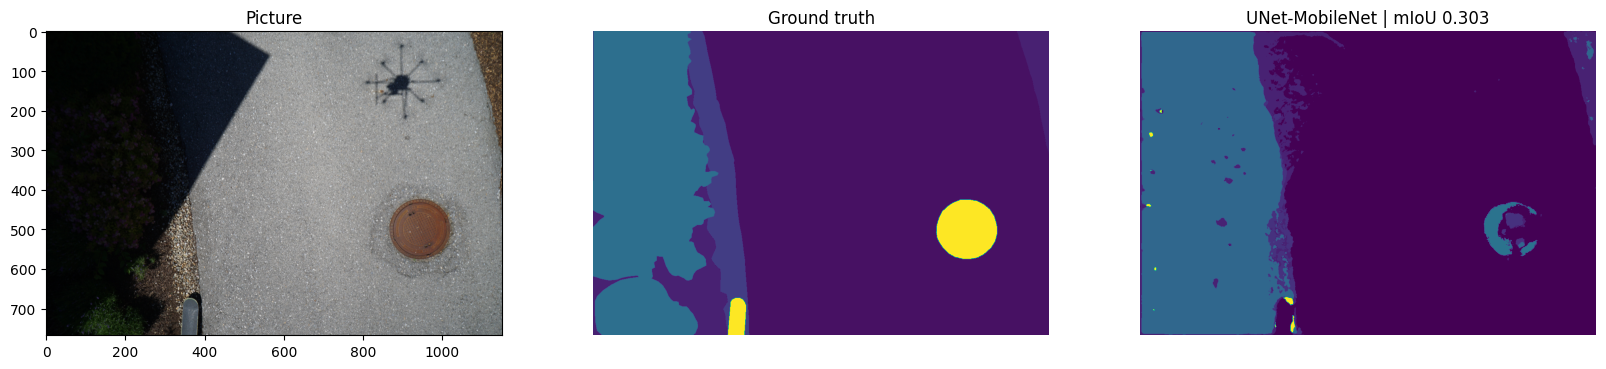

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

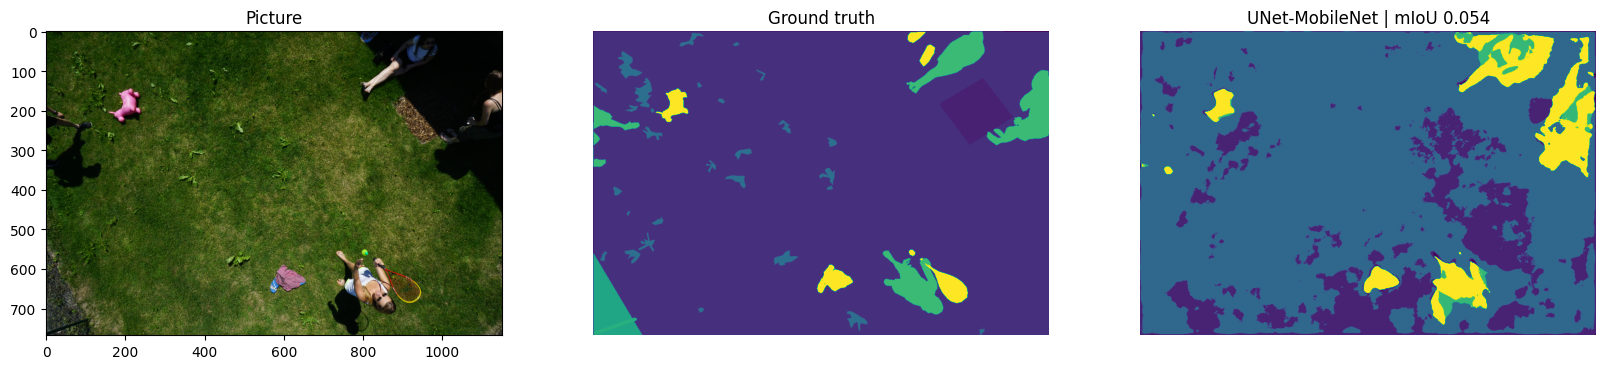

In [32]:
image3, mask3 = test_set[6]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()

In [33]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.17756462690182886


In [34]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.6372370684588397
